# Bag of Words

---

**Datasets:**
1. Dataset with apostrophe in regex and lemmatization
    - sentiment140/sentiment140_lem_all_with_apostrophe.csv
2. Dataset without apostrophe in regex and lemmatization
    - => partially less token in tweet compared to dataset with apostrophe
    - sentiment140/sentiment140_lem_all_no_apostrophe.csv
3. Dataset with apostrophe in regex and stemming
    - sentiment140/sentiment140_stem_all_with_apostrophe.csv
4. Dataset without apostrophe in regex and stemming
    - => partially less token in tweet compared to dataset with apostrophe
    - sentiment140/sentiment140_stem_all_no_apostrophe.csv

---
 For MAX_FEATURES = 5000 and 5% of the dataset

**GridSearch Best Parameters**: {'metric': 'minkowski', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}



**Accuracy best parameters from GridSearch**:

|  | mit Apost. | ohne Apost. |
|--|--|--|
| Lem | 0.6803 | 0.6794 |
| Stem | 0.6851 | 0.6851 |

---
 For MAX_FEATURES = 10000 and 5% of the dataset

**GridSearch Best Parameters**: 
- {'metric': 'minkowski', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
- {'metric': 'minkowski', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
- {'metric': 'minkowski', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
- {'metric': 'minkowski', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}




**Accuracy best parameters from GridSearch**:

|  | mit Apost. | ohne Apost. |
|--|--|--|
| Lem | 0.6822 | 0.6804 |
| Stem | 0.6845 | 0.6856 |

---

 For MAX_FEATURES = 10000 and 10% of the dataset

**GridSearch Best Parameters**: 
- {'metric': 'minkowski', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}





**Accuracy best parameters from GridSearch**:

|  | mit Apost. | ohne Apost. |
|--|--|--|
| Lem | 0.6965 |  |
| Stem |  |  |

---
**1. Dataset:** 

**MAX_FEATURE comparison:**

|  | 5000 | get_max_features |
|---|---|---|
| N_NEIGHBORS=1, 5% | 0.6525 | 0.65 |
| N_NEIGHBORS=5, 5% | 0.6722 | 0.6722 |
| N_NEIGHBORS=5, 10% | 0.6900 | 0.691 |


---

Goal: train full dataset with best parameters from GridSearch and 
- MAX_FEATURES = unlimited => MemoryError
- MAX_FEATURES = 25000 => interrupt after 6.5 h


In [27]:
# Imports

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
import numpy as np

pd.options.display.max_colwidth = None

## 1. Dataset with apostrophe in regex and lemmatization

In [28]:
DATA_NAME = 'sentiment140/sentiment140_lem_all_with_apostrophe.csv'
ENCODING = 'latin-1'
COLUMN_NAMES = ['sentiment', 'tweet']
NROWS = 1600000

df_with_apostrophe = pd.read_csv(DATA_NAME,
                 encoding=ENCODING,
                 header=None,
                 names=COLUMN_NAMES,
                 nrows=NROWS
                 )

df_with_apostrophe.head(5)

,sentiment,tweet
0,0,aww that 's bummer shoulda got david carr third day
1,0,upset ca n't update facebook texting might cry result school today also blah
2,0,dived many time ball managed save 50 rest go bound
3,0,whole body feel itchy like fire
4,0,behaving i 'm mad ca n't see


In [29]:
# create smaller datasets with 5% and 10% of the data for testing
length_of_df_w = df_with_apostrophe.shape[0]
df_with_apostrophe_10 = df_with_apostrophe.iloc[int((length_of_df_w/2) - 80000):int((length_of_df_w/2) + 80000)]
df_with_apostrophe_5 = df_with_apostrophe.iloc[int((length_of_df_w/2) - 40000):int((length_of_df_w/2) + 40000)]

print('10% df', df_with_apostrophe_10.sentiment.value_counts())
print('5% df', df_with_apostrophe_5.sentiment.value_counts())


10% df sentiment
0    80067
1    79933
Name: count, dtype: int64
5% df sentiment
0    40067
1    39933
Name: count, dtype: int64


In [6]:
# get the value for MAX_FEATURES for a certain quantile

def get_max_features(dataset, quantil):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(dataset)

    word_list = vectorizer.get_feature_names_out()
    word_count = np.array(X.sum(axis=0)).flatten()

    word_dict = [word_list, word_count]
    df_words = pd.DataFrame(word_dict).T
    df_words.rename(columns={0:'word', 1:'anzahl'}, inplace=True)

    df_words = df_words.sort_values(by='anzahl', ascending=False)
    df_words = df_words.reset_index(drop=True)

    data = df_words['anzahl']
    threshold = df_words.anzahl.sum() * quantil*0.01

    def accumulate_to_threshold(data, threshold):
        total = 0
        for index, item in enumerate(data):
            total += item
            if total > threshold:
                print(index)
                return index

    return accumulate_to_threshold(data, threshold)


In [21]:
USED_DF = df_with_apostrophe_10
QUANTIL = 95
MAX_FEATURES = get_max_features(USED_DF.tweet, QUANTIL)
TEST_SIZE = 0.2
N_NEIGHBORS = 1

18412


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
                                    USED_DF.tweet,
                                    USED_DF.sentiment,
                                    test_size=TEST_SIZE,
                                    random_state=42
                                    )
print(y_train.value_counts())
print(y_test.value_counts())

sentiment
0    64176
1    63824
Name: count, dtype: int64
sentiment
1    16109
0    15891
Name: count, dtype: int64


In [23]:
# Bag of Words model
vectorizer = CountVectorizer(max_features=MAX_FEATURES)
BoWvectorizer = vectorizer.fit(USED_DF.tweet)

X_train_bow = BoWvectorizer.transform(X_train)
X_test_bow = BoWvectorizer.transform(X_test)

print("X_train_shape", X_train_bow.toarray().shape)
print("X_test_shape", X_test_bow.toarray().shape)
print("y_train_shape", y_train.shape)
print("y_test_shape", y_test.shape)

X_train_shape (128000, 18412)
X_test_shape (32000, 18412)
y_train_shape (128000,)
y_test_shape (32000,)


In [19]:
clf_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS).fit(X_train_bow, y_train)

pred_X_train = clf_knn.predict(X_train_bow)
pred_X_test = clf_knn.predict(X_test_bow)

print('classification report test\n', metrics.classification_report(y_test, pred_X_test))
print('test accuracy', metrics.accuracy_score(y_test, pred_X_test))
print('train accuracy', metrics.accuracy_score(y_train, pred_X_train))

classification report test
               precision    recall  f1-score   support

           0       0.66      0.67      0.66     15891
           1       0.67      0.66      0.66     16109

    accuracy                           0.66     32000
   macro avg       0.66      0.66      0.66     32000
weighted avg       0.66      0.66      0.66     32000

test accuracy 0.6619375
train accuracy 0.9908984375


#### GridSearch for best KNN parameters

In [41]:
PARAM_GRID = {'n_neighbors': [1, 5, 9, 13],
              'p': [1, 2],
              'weights': ('uniform', 'distance'),
              'metric': ['minkowski']
              }


grid = GridSearchCV(estimator=KNeighborsClassifier(),
                    param_grid=PARAM_GRID,
                    scoring='accuracy',
                    n_jobs=-1,
                    refit=True,
                    cv=5,
                    verbose=4
                    )

grid.fit(X_train_bow, y_train)

# Results
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'metric': 'minkowski', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
0.6965234375


In [42]:
# predict X_test for the best parameters
pred_grid = grid.predict(X_test_bow)

print('classification report grid test\n', metrics.classification_report(y_test, pred_grid))

classification report grid test
               precision    recall  f1-score   support

           0       0.73      0.64      0.68     15891
           1       0.69      0.76      0.72     16109

    accuracy                           0.70     32000
   macro avg       0.71      0.70      0.70     32000
weighted avg       0.71      0.70      0.70     32000



#### Testing different values for n_neighbors (metric, p, weights values from GredSearch)

In [ ]:
# KNN model MAX_FEATURES = 5000 UND 5%

K_WS = 17
METRIC = 'minkowski'
P = 1
WEIGHTS = 'distance'


# save values in array for plotting
k_values = []
train_accuracy = []
accuracy = []
precision = []
recall = []
f1 = []

for k in range(1,K_WS+1, 2):
  k_val = k

  print('start with k = ', k)
  clf_knn_2 = KNeighborsClassifier(n_neighbors=k, metric=METRIC, p=P, weights=WEIGHTS).fit(X_train_bow, y_train)

  pred_train = clf_knn_2.predict(X_train_bow)
  pred_test = clf_knn_2.predict(X_test_bow)

  k_values.append(k)
  train_accuracy.append(metrics.accuracy_score(y_train, pred_train))
  accuracy.append(metrics.accuracy_score(y_test, pred_test))
  precision.append(metrics.precision_score(y_test, pred_test))
  recall.append(metrics.recall_score(y_test, pred_test))
  f1.append(metrics.f1_score(y_test, pred_test).round(3))


  print('done with ', k)

start with k =  1
done with  1
start with k =  3
done with  3
start with k =  5
done with  5
start with k =  7
done with  7
start with k =  9
done with  9
start with k =  11
done with  11
start with k =  13
done with  13
start with k =  15
done with  15
start with k =  17
done with  17


<Axes: title={'center': 'Metrics for KNN classifier \n (5% dataset, train-test split 80/20,\n dataset with apost., lemmatized tweets) '}, xlabel='k_values'>

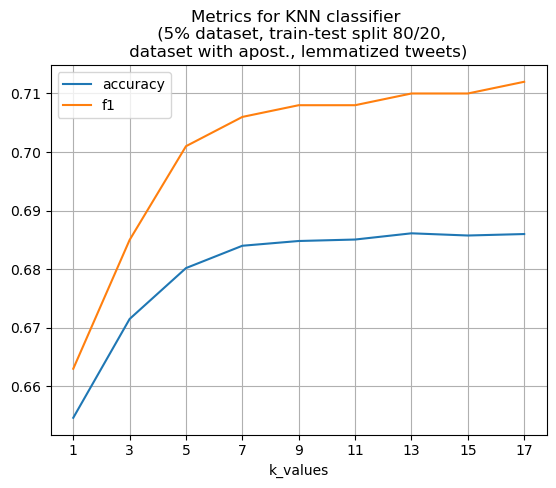

In [75]:
metrics_array = np.array([k_values,train_accuracy, accuracy, precision, recall, f1])
metrics_df = pd.DataFrame(metrics_array.T, columns=['k_values', 'train_accuracy', 'accuracy', 'precision', 'recall', 'f1'])

metrics_df.plot.line(x='k_values', y=['accuracy', 'f1'], 
                     title='Metrics for KNN classifier \n (5% dataset, train-test split 80/20,\n dataset with apost., lemmatized tweets) ',
                     xticks=range(1,19,2),
                     grid=True
                     )

## 2. Dataset without apostrophe in regex and lemmatization

In [30]:
DATA_NAME = 'sentiment140/sentiment140_lem_all_no_apostrophe.csv'
ENCODING = 'latin-1'
COLUMN_NAMES = ['sentiment', 'tweet']
NROWS = 1600000

df_no_apostrophe = pd.read_csv(DATA_NAME,
                                encoding=ENCODING,
                                header=None,
                                names=COLUMN_NAMES,
                                nrows=NROWS
                                )

df_no_apostrophe.head(5)

,sentiment,tweet
0,0,aww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result school today also blah
2,0,dived many time ball managed save 50 rest go bound
3,0,whole body feel itchy like fire
4,0,behaving mad see


In [31]:
# create smaller dataset
length_of_df_w = df_no_apostrophe.shape[0]
df_no_apostrophe_10 = df_no_apostrophe.iloc[int((length_of_df_w/2) - 80000):int((length_of_df_w/2) + 80000)]
df_no_apostrophe_5 = df_no_apostrophe.iloc[int((length_of_df_w/2) - 40000):int((length_of_df_w/2) + 40000)]

print('10% df', df_no_apostrophe_10.sentiment.value_counts())
print('5% df', df_no_apostrophe_5.sentiment.value_counts())

10% df sentiment
0    80081
1    79919
Name: count, dtype: int64
5% df sentiment
0    40081
1    39919
Name: count, dtype: int64


In [32]:
USED_DF = df_no_apostrophe_5
MAX_FEATURES = 10000
TEST_SIZE = 0.2
N_NEIGHBORS = 1

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
                                    USED_DF.tweet,
                                    USED_DF.sentiment,
                                    test_size=TEST_SIZE,
                                    random_state=42
                                    )

In [34]:
# Bag of Words model
vectorizer = CountVectorizer(max_features=MAX_FEATURES)
BoWvectorizer = vectorizer.fit(USED_DF.tweet)

X_train = BoWvectorizer.transform(X_train)
X_test = BoWvectorizer.transform(X_test)

print("X_train_shape", X_train.toarray().shape)
print("X_test_shape", X_test.toarray().shape)
print("y_train_shape", y_train.shape)
print("y_test_shape", y_test.shape)

X_train_shape (64000, 10000)
X_test_shape (16000, 10000)
y_train_shape (64000,)
y_test_shape (16000,)


In [35]:
clf_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS).fit(X_train, y_train)

pred_X_train = clf_knn.predict(X_train)
pred_X_test = clf_knn.predict(X_test)

print('classification report test\n', metrics.classification_report(y_test, pred_X_test))
print('test accuracy', metrics.accuracy_score(y_test, pred_X_test))
print('train accuracy', metrics.accuracy_score(y_train, pred_X_train))

classification report test
               precision    recall  f1-score   support

           0       0.66      0.65      0.65      7992
           1       0.65      0.66      0.66      8008

    accuracy                           0.65     16000
   macro avg       0.65      0.65      0.65     16000
weighted avg       0.65      0.65      0.65     16000

test accuracy 0.654
train accuracy 0.9900625


#### GridSearch for best KNN parameters

In [36]:
PARAM_GRID = {'n_neighbors': [1, 5, 9, 13],
              'p': [1, 2],
              'weights': ('uniform', 'distance'),
              'metric': ['minkowski']
              }


grid = GridSearchCV(estimator=KNeighborsClassifier(),
                    param_grid=PARAM_GRID,
                    scoring='accuracy',
                    n_jobs=-1,
                    refit=True,
                    cv=5,
                    verbose=4
                    )

grid.fit(X_train, y_train)

# results
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'metric': 'minkowski', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
0.680375


In [37]:
# predict X_test for the best parameters
pred_grid = grid.predict(X_test)

print('classification report grid test\n', metrics.classification_report(y_test, pred_grid))

classification report grid test
               precision    recall  f1-score   support

           0       0.71      0.62      0.67      7992
           1       0.67      0.75      0.71      8008

    accuracy                           0.69     16000
   macro avg       0.69      0.69      0.69     16000
weighted avg       0.69      0.69      0.69     16000



## 3. Dataset with apostrophe in regex and stemming

In [ ]:
DATA_NAME = 'sentiment140/sentiment140_stem_all_with_apostrophe.csv'
ENCODING = 'latin-1'
COLUMN_NAMES = ['sentiment', 'tweet']
NROWS = 1600000

df_with_apostrophe_stem = pd.read_csv(DATA_NAME,
                                encoding=ENCODING,
                                header=None,
                                names=COLUMN_NAMES,
                                nrows=NROWS
                                )

df_with_apostrophe_stem.head(5)

,sentiment,tweet
0,0,"['aww', 'that', ""'s"", 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day']"
1,0,"['upset', 'ca', ""n't"", 'updat', 'facebook', 'text', 'might', 'cri', 'result', 'school', 'today', 'also', 'blah']"
2,0,"['dive', 'mani', 'time', 'ball', 'manag', 'save', '50', 'rest', 'go', 'bound']"
3,0,"['whole', 'bodi', 'feel', 'itchi', 'like', 'fire']"
4,0,"['behav', 'i', ""'m"", 'mad', 'ca', ""n't"", 'see']"


In [ ]:
# create smaller dataset
length_of_df_w = df_with_apostrophe_stem.shape[0]
df_with_apostrophe_stem_10 = df_with_apostrophe_stem.iloc[int((length_of_df_w/2) - 80000):int((length_of_df_w/2) + 80000)]
df_with_apostrophe_stem_5 = df_with_apostrophe_stem.iloc[int((length_of_df_w/2) - 40000):int((length_of_df_w/2) + 40000)]

print('10% df', df_with_apostrophe_stem_10.sentiment.value_counts())
print('5% df', df_with_apostrophe_stem_5.sentiment.value_counts())

10% df sentiment
0    80067
1    79933
Name: count, dtype: int64
5% df sentiment
0    40067
1    39933
Name: count, dtype: int64


In [ ]:
USED_DF = df_with_apostrophe_stem_10
MAX_FEATURES = 10000
TEST_SIZE = 0.2
N_NEIGHBORS = 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                    USED_DF.tweet,
                                    USED_DF.sentiment,
                                    test_size=TEST_SIZE,
                                    random_state=42
                                    )

In [ ]:
# Bag of Words model
vectorizer = CountVectorizer(max_features=MAX_FEATURES)
BoWvectorizer = vectorizer.fit(USED_DF.tweet)

X_train = BoWvectorizer.transform(X_train)
X_test = BoWvectorizer.transform(X_test)

print("X_train_shape", X_train.toarray().shape)
print("X_test_shape", X_test.toarray().shape)
print("y_train_shape", y_train.shape)
print("y_test_shape", y_test.shape)

X_train_shape (64000, 10000)
X_test_shape (16000, 10000)
y_train_shape (64000,)
y_test_shape (16000,)


In [ ]:
clf_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS).fit(X_train, y_train)

pred_X_train = clf_knn.predict(X_train)
pred_X_test = clf_knn.predict(X_test)

print('classification report test\n', metrics.classification_report(y_test, pred_X_test))
print('test accuracy', metrics.accuracy_score(y_test, pred_X_test))
print('train accuracy', metrics.accuracy_score(y_train, pred_X_train))

classification report test
               precision    recall  f1-score   support

           0       0.65      0.65      0.65      7991
           1       0.65      0.66      0.66      8009

    accuracy                           0.65     16000
   macro avg       0.65      0.65      0.65     16000
weighted avg       0.65      0.65      0.65     16000

test accuracy 0.6535625
train accuracy 0.9916875


#### GridSearch for best KNN parameters

In [ ]:
PARAM_GRID = {'n_neighbors': [1, 5, 9, 13],
              'p': [1, 2],
              'weights': ('uniform', 'distance'),
              'metric': ['minkowski']
              }


grid = GridSearchCV(estimator=KNeighborsClassifier(),
                    param_grid=PARAM_GRID,
                    scoring='accuracy',
                    n_jobs=-1,
                    refit=True,
                    cv=5,
                    verbose=4
                    )

grid.fit(X_train, y_train)

# results
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'metric': 'minkowski', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
0.6845312499999999


In [ ]:
# predict X_test for the best parameters
pred_grid = grid.predict(X_test)

print('classification report grid test\n', metrics.classification_report(y_test, pred_grid))

classification report grid test
               precision    recall  f1-score   support

           0       0.71      0.64      0.67      7991
           1       0.67      0.74      0.71      8009

    accuracy                           0.69     16000
   macro avg       0.69      0.69      0.69     16000
weighted avg       0.69      0.69      0.69     16000



## 4. Dataset without apostrophe in regex and stemming

In [ ]:
DATA_NAME = 'sentiment140/sentiment140_stem_all_no_apostrophe.csv'
ENCODING = 'latin-1'
COLUMN_NAMES = ['sentiment', 'tweet']
NROWS = 1600000

df_no_apostrophe_stem = pd.read_csv(DATA_NAME,
                                encoding=ENCODING,
                                header=None,
                                names=COLUMN_NAMES,
                                nrows=NROWS
                                )

df_no_apostrophe_stem.head(5)

,sentiment,tweet
0,0,"['aww', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day']"
1,0,"['upset', 'updat', 'facebook', 'text', 'might', 'cri', 'result', 'school', 'today', 'also', 'blah']"
2,0,"['dive', 'mani', 'time', 'ball', 'manag', 'save', '50', 'rest', 'go', 'bound']"
3,0,"['whole', 'bodi', 'feel', 'itchi', 'like', 'fire']"
4,0,"['behav', 'mad', 'see']"


In [ ]:
# create smaller dataset
length_of_df_w = df_no_apostrophe_stem.shape[0]
df_no_apostrophe_stem_10 = df_no_apostrophe_stem.iloc[int((length_of_df_w/2) - 80000):int((length_of_df_w/2) + 80000)]
df_no_apostrophe_stem_5 = df_no_apostrophe_stem.iloc[int((length_of_df_w/2) - 40000):int((length_of_df_w/2) + 40000)]

print('10% df', df_no_apostrophe_stem_10.sentiment.value_counts())
print('5% df', df_no_apostrophe_stem_5.sentiment.value_counts())

10% df sentiment
0    80081
1    79919
Name: count, dtype: int64
5% df sentiment
0    40081
1    39919
Name: count, dtype: int64


In [ ]:
USED_DF = df_no_apostrophe_stem_10
MAX_FEATURES = 10000
TEST_SIZE = 0.2
N_NEIGHBORS = 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                    USED_DF.tweet,
                                    USED_DF.sentiment,
                                    test_size=TEST_SIZE,
                                    random_state=42
                                    )

In [ ]:
# Bag of Words model
vectorizer = CountVectorizer(max_features=MAX_FEATURES)
BoWvectorizer = vectorizer.fit(USED_DF.tweet)

X_train = BoWvectorizer.transform(X_train)
X_test = BoWvectorizer.transform(X_test)

print("X_train_shape", X_train.toarray().shape)
print("X_test_shape", X_test.toarray().shape)
print("y_train_shape", y_train.shape)
print("y_test_shape", y_test.shape)

X_train_shape (64000, 10000)
X_test_shape (16000, 10000)
y_train_shape (64000,)
y_test_shape (16000,)


In [ ]:
clf_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS).fit(X_train, y_train)

pred_X_train = clf_knn.predict(X_train)
pred_X_test = clf_knn.predict(X_test)

print('classification report test\n', metrics.classification_report(y_test, pred_X_test))
print('test accuracy', metrics.accuracy_score(y_test, pred_X_test))
print('train accuracy', metrics.accuracy_score(y_train, pred_X_train))

classification report test
               precision    recall  f1-score   support

           0       0.66      0.64      0.65      7992
           1       0.65      0.67      0.66      8008

    accuracy                           0.65     16000
   macro avg       0.65      0.65      0.65     16000
weighted avg       0.65      0.65      0.65     16000

test accuracy 0.6545
train accuracy 0.990640625


#### GridSearch for best KNN parameters

In [ ]:
PARAM_GRID = {'n_neighbors': [1, 5, 9, 13],
              'p': [1, 2],
              'weights': ('uniform', 'distance'),
              'metric': ['minkowski']
              }


grid = GridSearchCV(estimator=KNeighborsClassifier(),
                    param_grid=PARAM_GRID,
                    scoring='accuracy',
                    n_jobs=-1,
                    refit=True,
                    cv=5,
                    verbose=4
                    )

grid.fit(X_train, y_train)

# results
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'metric': 'minkowski', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
0.6855625


In [ ]:
# predict X_test for the best parameters
pred_grid = grid.predict(X_test)

print('classification report grid test\n', metrics.classification_report(y_test, pred_grid))

classification report grid test
               precision    recall  f1-score   support

           0       0.73      0.61      0.67      7992
           1       0.67      0.77      0.71      8008

    accuracy                           0.69     16000
   macro avg       0.70      0.69      0.69     16000
weighted avg       0.70      0.69      0.69     16000

